In [1]:
import matplotlib.pyplot as plt  
import networkx as nx  
import numpy as np
from multiprocessing import Pool
from string import ascii_letters as abc 
abc = [x for x in abc]

In [54]:
def get_person(x):
    colors, adjacency_list = x
    return World_Map(colors, adjacency_list)

class World_Map:
    def __init__(self, colors, adjacency_list):
        self.colors = colors
        self.adjacency_list = adjacency_list
        self.n_nodes = len(self.colors)
        self.fitness, self.graph_nx = self.__convert_to_nxgraph(self.colors, self.adjacency_list)
        
    def __convert_to_nxgraph(self, colors, adjacency_list):
        G = nx.Graph()
        counter = 0  #the numberz of edges connecting same colors
        number_of_edges_twice = 0

        for index, node_color in enumerate(colors):
            G.add_node(index, color=node_color)  #Index the label
            for neighbour in adjacency_list[index]:
                #input edge
                G.add_edge(index, neighbour, illegal=False)  #illegal bool denotes whether nodes of the same color
                number_of_edges_twice += 1
                if node_color == colors[neighbour]:
                    G[index][neighbour]['illegal'] = True
                    counter += 1

        return number_of_edges_twice/2 - counter/2, G

    def print_me(self, figure_number=-1, figure_title=''):
        color_mapping = {True: 'r', False: 'g'}

        node_list = self.graph_nx.nodes(data=True)
        edge_list = self.graph_nx.edges(data=True)

        colors_nodes = [element[1]['color'] for element in node_list]
        colors_edges = [color_mapping[element[2]['illegal']] for element in edge_list]
        plt.figure(figure_number)
        plt.title(figure_title)
        nx.draw_networkx(self.graph_nx, with_labels=True, node_color=colors_nodes, edge_color=colors_edges)
        plt.draw()

# Generate random graph - in our case we care about adjacency list
def generate_random_graph(number_of_nodes, probability_of_edge):
    G = nx.fast_gnp_random_graph(number_of_nodes, probability_of_edge, seed=None, directed=False)
    edges = []
    for i in range(number_of_nodes):
        temp1 = G.adj[i]
        edges.append(list(G.adj[i].keys()))
    return G.number_of_edges(), edges

def generate_random_graph_from_G(G):
    edges = []
    for i in range(len(G.nodes)):
        temp1 = G.adj[i]
        edges.append(list(G.adj[i].keys()))
    return G.number_of_edges(), edges

# Creates list of pairs from the input population
def parent_selection(input_population, number_of_pairs, method='FPS'):
    input_n = len(input_population)

    if method == 'FPS':  # Fitness proportional selection
        # our fitness is non-negative so we can apply a simple formula  fitness_m/sum(fitness_i)
        fitness_sum = sum([person.fitness for person in input_population])
        probabilities = np.array([person.fitness / fitness_sum for person in input_population])

        I_x = np.random.choice(np.arange(0, input_n), number_of_pairs, p=probabilities)
        I_y = np.random.choice(np.arange(0, input_n), number_of_pairs, p=probabilities)

        return [(input_population[I_x[i]], input_population[I_y[i]]) for i in range(number_of_pairs)]

# Define a genetic operator
def genetic_operator(pair_of_parents, method='SPC', n_colors=3):
    n_nodes = pair_of_parents[0].n_nodes
    al = pair_of_parents[0].adjacency_list

    if method == 'mutation':
        # this method does not need a pair of parents, it inputs only one person
        # Idea:
        node1 = np.random.randint(0, n_nodes)
        node2 = np.random.randint(0, n_nodes)

        colors = set(abc[:n_colors])
        mapper = {x: [y for y in colors if y != x] for x in colors}

        child_one_colors = pair_of_parents[0].colors
        child_two_colors = pair_of_parents[1].colors

        def get_child(child_colors):
            child_colors = list(child_colors)
            for i in range(len(child_colors)):
                invalid = set()
                for j in al[i]: 
                    if child_colors[j] == child_colors[i]: invalid.add(child_colors[j])
                if invalid:
                    valid = list(colors.difference(invalid))
                    child_colors[i] = np.random.choice(valid, 1)[0]
            return "".join(child_colors) 

        child_one_colors = get_child(child_one_colors)
        child_two_colors = get_child(child_two_colors)
        return (child_one_colors, al), (child_two_colors, al)

    if method == 'SPC':  # Single point crossover
        # Step 1) Select a random point
        # Step 2) All colours to the left will be from parent 1, all parent to the right are from parent 2
        point = np.random.randint(0, n_nodes)

        parent_1_colors = pair_of_parents[0].colors
        parent_2_colors = pair_of_parents[1].colors

        child_one_colors = parent_1_colors[:point] + parent_2_colors[point:]
        child_two_colors = parent_2_colors[:point] + parent_1_colors[point:]

        return (child_one_colors, al), (child_two_colors, al)

# Population update
def population_update(input_population, output_population_size, generation_change_method='Elitism',
                      percentage_to_keep=0.1, genetic_op='SPC', n_colors=3):
    input_population_size = len(input_population)
    output_population = []

    if generation_change_method == 'Elitism':
        # We keep the best x percent of the input population
        input_population.sort(key=lambda x: x.fitness, reverse=True)
        output_population += input_population[:int(input_population_size * percentage_to_keep)]

        list_of_parent_pairs = parent_selection(input_population, input_population_size // 2)
        childs = []
        pair_index = 0
        while len(output_population)+len(childs) < output_population_size:
            child_1, child_2 = genetic_operator(list_of_parent_pairs[pair_index], method=genetic_op, n_colors=n_colors)
            childs.append(child_1); childs.append(child_2)
            pair_index += 1
    
    with Pool(len(childs)) as p:
        childs = p.map(get_person, childs)

    output_population += childs 
    
    return output_population

# Generate random initial population
def generate_random_initial_population(population_size, n_nodes, al, n_colors):
    input_population = []
    colors = abc[:n_colors]
    # Generate random initial population
    for _ in range(population_size):
        color_list = np.random.choice(colors, n_nodes, replace=True)
        color_string = "".join(color_list)
        input_population.append((color_string, al))

    with Pool(len(input_population)) as p:
        input_population = p.map(get_person, input_population)

    print('A random population of ' + str(population_size) + ' people was created')

    return input_population

# Find fittest
def find_fittest(input_population):
    fitness_list = [person.fitness for person in input_population]
    ix = np.argmax(fitness_list)
    return fitness_list, ix, input_population[ix]

# Roll the evolution
def evolution(input_population, n_generations, population_size, percentage_to_keep=0.1, genetic_op='SPC', n_colors=3):
    # We will find the histogram for each generation and the fittest person
    results_fitness = []
    results_fittest = []

    for i in range(n_generations):
        print('Your population is in the ' + str(i + 1) + '-th generation')
        # Save results
        fitness_list, ix, fittest_coloring = find_fittest(input_population)
        results_fitness.append(fitness_list)
        results_fittest.append(fittest_coloring)
        # Print highest fitness
        print('The fittest person is: ' + str(max(fitness_list)))
        genetic_op = np.random.choice(['SPC', 'mutation'], 1)
        # Update
        output_population = population_update(input_population, population_size, percentage_to_keep=percentage_to_keep, genetic_op=genetic_op, n_colors=n_colors)
        input_population = output_population

    return results_fitness, results_fittest

# Visualize results
def visualize_results(results_fitness, results_fittest, number_of_generations_to_visualize=6):
    # Important
    # total_generations = len(results_fitness)

    # # Pick generations to visualize
    # I = list(np.random.choice(list(range(1, total_generations-1)), number_of_generations_to_visualize - 2, replace=False))
    # I += [0, total_generations - 1]
    # I.sort()
    # print("Visualized generations: ", end='')
    # print(I)

    # # Main
    # for i, order in enumerate(I):
    #     # print fittest
    #     results_fittest[order].print_me(figure_number=i, figure_title='generation: ' + str(order + 1) + ', fitness: ' + str(results_fittest[order].fitness))
    #     # Print histogram
    #     plt.figure(-i-1)  # means nothing
    #     plt.hist(results_fitness[order])
    #     plt.title('Generation_number: ' + str(order + 1))
    #     plt.draw()
    y = [x.fitness for x in results_fittest]
    plt.plot(range(len(results_fittest)), y)


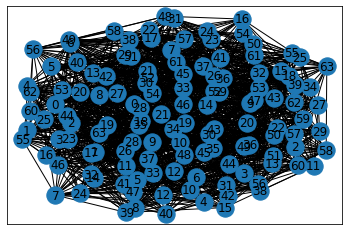

In [55]:
import base64
import requests

def get_graph(name):
    doc = f"https://raw.githubusercontent.com/carloscerlira/Datasets/master/DIMACS%20Graph%20Coloring/{name}.txt"
    doc = requests.get(doc)
    raw_edges = doc.text
    raw_edges = raw_edges.split("\n")
    edges = []
    for line in raw_edges:
        line = line.strip()
        line = line.split(" ")
        line.pop(0)
        x, y = map(int, line)
        x, y = x-1, y-1
        edges.append((x, y))
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw_networkx(G)
    return G 

In [ ]:
if __name__ == '__main__': 
    G = get_graph("queen8_8")
    population_size = 50  
    # number_of_edges, al = generate_random_graph(n_nodes, 0.3)  # The graph architecture is generated randomly
    number_of_edges, al = generate_random_graph_from_G(G)
    n_nodes = len(G.nodes) 
    n_generations = 200
    genetic_op = 'SPC'  
    percentage_of_parents_to_keep = 0.3  
    n_colors = 9
    print("Number of edges: " + str(number_of_edges))

    input_population = generate_random_initial_population(population_size, n_nodes, al, n_colors=n_colors)
    results_fitness, results_fittest = evolution(input_population, n_generations, population_size,
                                                percentage_to_keep=percentage_of_parents_to_keep,
                                                genetic_op=genetic_op, n_colors=n_colors)
    visualize_results(results_fitness, results_fittest)
    plt.show()

Number of edges: 728
A random population of 50 people was created
Your population is in the 1-th generation
The fittest person is: 664.0
Your population is in the 2-th generation
The fittest person is: 670.0
Your population is in the 3-th generation
The fittest person is: 675.0
Your population is in the 4-th generation
The fittest person is: 675.0
Your population is in the 5-th generation
The fittest person is: 675.0
Your population is in the 6-th generation
The fittest person is: 675.0
Your population is in the 7-th generation
The fittest person is: 675.0
Your population is in the 8-th generation
The fittest person is: 675.0
Your population is in the 9-th generation
The fittest person is: 675.0
Your population is in the 10-th generation
The fittest person is: 675.0
Your population is in the 11-th generation
The fittest person is: 675.0
Your population is in the 12-th generation
The fittest person is: 675.0
Your population is in the 13-th generation
The fittest person is: 675.0
Your po